In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
####### VAE #######
# !pip install tensorflow
# !pip3 install tf-nightly

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
import argparse
import os
import re

import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import Lambda, Input, Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import backend as K
import soundfile as sf

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
# import eli5
# from eli5.sklearn import PermutationImportance

import pickle
import joblib

In [ ]:
# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

## wav -> feature dataframe

In [ ]:
N_FFT = 2048  # FFT window size
HOP_LENGTH = 512 # number audio of frames between STFT columns
WAV_LENGTH = 661794 # 기존 30초짜리 wav 파일의 length

col_name = ['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
            'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var',
            'rolloff_mean','rolloff_var', 'zero_crossing_rate_mean','zero_crossing_rate_var', 'harmony_mean',
            'harmony_var','perceptr_mean','perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var',
            'mfcc3_mean','mfcc3_var','mfcc4_mean', 'mfcc4_var','mfcc5_mean', 'mfcc5_var','mfcc6_mean','mfcc6_var',
            'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean',
            'mfcc10_var','mfcc11_mean','mfcc11_var','mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var',
            'mfcc14_mean','mfcc14_var','mfcc15_mean','mfcc15_var', 'mfcc16_mean','mfcc16_var', 'mfcc17_mean',
            'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var','mfcc20_mean', 'mfcc20_var']

# 30 sec
# wav 파일 하나 -> 30sec feature extraction -> dataframe
def table_arr(wav_data):
  n_li = []
  y, sr = librosa.load(wav_data)
  audio_file, _ = librosa.effects.trim(y)

  # file_name
  n_li.append(str(wav_data)[34:])   # 파일명에 따라 변경..
  # length
  n_li.append(len(audio_file))
  # chroma_stft
  chroma_stft = librosa.feature.chroma_stft(audio_file, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(chroma_stft))
  n_li.append(np.var(chroma_stft))
  # rms
  rms = librosa.feature.rms(audio_file, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(rms))
  n_li.append(np.var(rms))
  # spectral_centroid
  spec_cent = librosa.feature.spectral_centroid(audio_file, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(spec_cent))
  n_li.append(np.var(spec_cent))
  # spectral_bandwidth
  spec_bw = librosa.feature.spectral_bandwidth(audio_file, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(spec_bw))
  n_li.append(np.var(spec_bw))
  # rolloff
  rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(rolloff))
  n_li.append(np.var(rolloff))
  # zero_crossing_rate
  zcr = librosa.feature.zero_crossing_rate(audio_file, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(zcr))
  n_li.append(np.var(zcr))
  # harmony
  harmony = librosa.effects.harmonic(audio_file)
  n_li.append(np.mean(harmony))
  n_li.append(np.var(harmony))
  # perceptr
  perc = librosa.effects.percussive(audio_file)
  n_li.append(np.mean(perc))
  n_li.append(np.var(perc))
  # tempo
  tempo = librosa.beat.tempo(audio_file)
  n_li.append(tempo[0])
  # mfcc
  mfccs = librosa.feature.mfcc(y=audio_file, sr=sr)
  for i in range(len(mfccs)):
    n_li.append(np.mean(mfccs[i]))
    n_li.append(np.var(mfccs[i]))
  
  return n_li

def feature_30_sec(wav_data):
  n_li = table_arr(wav_data)
  df_30 = pd.DataFrame([n_li], columns=col_name)
  return df_30


# 3 sec
# wav(30sec) -> 3sec짜리 wav로 쪼개기
def trim_audio(wav_data, y, sr):
  sec = 3   # 3초짜리
  audio_file, _ = librosa.effects.trim(y)
  
  # 기존 30초 wav보다 짧다면
  if len(audio_file) < WAV_LENGTH:  
    for i in range(9):
      ny = y[sr*sec*i:sr*sec*(i+1)]
      sf.write(str(wav_data)[:-3] + str(i) + '.wav', ny, sr)

    # 마지막 wav는 후반부 3초로
    ny = y[-sr*sec:]
    sf.write(str(wav_data)[:-3] +'9.wav', ny, sr)

  # 기존 30초 wav와 길이가 같다면
  else:
    for i in range(10):
      ny = y[sr*sec*i:sr*sec*(i+1)]
      sf.write(str(wav_data)[:-3] + str(i) + '.wav', ny, sr)

# wav 파일 하나 -> 3sec feature extraction -> dataframe
def feature_3_sec(wav_data):
  y, sr = librosa.load(wav_data)
  trim_audio(wav_data, y, sr)   # 3초짜리 10개 wav 파일로 쪼개고

  total_table = []
  for i in range(10): # 10개 파일별로 feature 추출한 리스트 -> 행으로 합치기
    # print("str(wav_data)[:-3] : ", str(wav_data)[:-3], "str(i) : ", str(i))
    li_ = table_arr(str(wav_data)[:-3] + str(i)+'.wav')
    total_table.append(li_)
    os.remove(str(wav_data)[:-3] + str(i)+'.wav') # 만들었던 3초짜리 데이터 삭제

  df_3 = pd.DataFrame(total_table, columns=col_name)
  return df_3  

# 생성 음악 파일 test

In [ ]:
def cleaning(x):
  if str(x).find("_") != -1:
    return str(x)[:-1]
  return str(x)

def count_df(wav_file):
  wav_file = wav_file.sort_values(by='filename', ascending=True)
  wav_file.reset_index(inplace=True, drop=True)

  ##############################    PCA   #######################################

  # pca 전 열 제거
  filename = wav_file.loc[:, 'filename']
  X = wav_file.drop(columns=['filename', 'length'])

  # 정규화
  cols = X.columns
  min_max_scaler = preprocessing.MinMaxScaler()
  np_scaled = min_max_scaler.fit_transform(X)
  X = pd.DataFrame(np_scaled, columns = cols)

  pca = PCA(n_components=30)
  pcs = pca.fit_transform(X)
  X = pd.DataFrame(data=pcs, columns = ['pc'+str(j) for j in range(30)])

  ##############################    예측    #######################################

  # 해당 분류모델 예측값
  new_pred = model.predict(X)  
  X['pred'] = new_pred

  result_df = []
  for i in range(int(len(X)/10)) :
    v = X.loc[10*i:10*i+9, 'pred'].value_counts()  # pred count
    t = pd.DataFrame(v)
    t = t.reset_index()

    # wav 파일 하나당 new_row 하나
    new_row = []
    new_row.append(filename[10*i])  # 1. filename

    # 2. ex_label (기존 label)
    val = str(wav_df.loc[0, 'filename']).find(vae_path) # 파일명(파일 경로)에서 'vae_' 찾아서 index 리턴
    new_row.append(str(wav_df.loc[10*i, 'filename'])[val+4:-8])

    if len(t) == 1 or (len(t) > 1 and t.iloc[0,1] > t.iloc[1,1]) : # count max값 1개
      new_row.append(t.iloc[0,0]) # 3. total_pred
      new_row.append(t.iloc[0,0]) # 4. same_pred -> 최종 max가 하나여도 일단 넣음!
    
    else:
      new_row.append('-1')  # count max값이 여러 개 -> 'total_pred' = '-1'

      same_preds = [t.iloc[0,0]]
      for j in range(1, len(t)):
        if t.iloc[j,1] == t.iloc[0,1]:  # 제일 count 큰 애랑 같은 count면
          same_preds.append(t.iloc[j,0])  # same_preds에 추가
        else:
          break
      new_row.append(same_preds)

    result_df.append(new_row)

  return result_df

In [ ]:
PATH = '/content/drive/MyDrive/기계팀플/Data/genres_generated(clean)/'
vae_path = 'vae_'

# model : nb, lg, sgd, knn, dt, rf, svm, nn, xgb, xgbrf
model = joblib.load('/content/drive/MyDrive/기계팀플/Model/sgd_pca30.pkl')

result_df = []  # 최종 df

In [ ]:
# # 전체 데이터 불러와서 3초로 분할 & 세로로 붙이기(총 1000개의 행)

# wav_df = pd.DataFrame()
# for filename in os.listdir(PATH):
#   wav_df = pd.concat([wav_df, feature_3_sec(PATH + filename)])  # feature dataframe

# wav_df.to_csv('/content/drive/MyDrive/기계팀플/Data/generated_all_3sec.csv', index=False)

In [ ]:
wav_df = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/generated_all_3sec.csv')
wav_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,Data/genres_generated(clean)/vae_hiphop_1.0.wav,66150,0.649012,0.042664,0.233933,0.000602,334.424469,1365.801250,405.895610,2940.431025,...,9.946751,6.582484,15.949812,6.314236,2.001956,6.209145,-10.687287,10.207195,-5.406503,8.567214
1,Data/genres_generated(clean)/vae_hiphop_1.1.wav,66150,0.672898,0.038027,0.247665,0.000618,323.670133,1143.389069,402.997154,1580.780568,...,10.431040,7.403444,15.914291,5.826558,1.466384,6.777391,-10.909385,8.379669,-4.945610,6.799612
2,Data/genres_generated(clean)/vae_hiphop_1.2.wav,66150,0.659488,0.043026,0.244080,0.000715,343.658810,1198.088150,412.836197,3791.829398,...,9.278729,10.960223,15.796875,8.029351,1.957645,7.054070,-10.418854,11.667451,-4.687717,7.047625
3,Data/genres_generated(clean)/vae_hiphop_1.3.wav,66150,0.665313,0.039228,0.240200,0.000485,344.744870,1141.450548,407.349267,2694.377572,...,10.701532,8.490515,16.283638,8.580648,1.023420,5.206451,-12.140578,5.325740,-6.013623,5.858634
4,Data/genres_generated(clean)/vae_hiphop_1.4.wav,66150,0.674641,0.041099,0.253226,0.000551,331.920690,930.118081,404.166777,1114.218232,...,10.847222,7.673827,16.166166,10.638223,1.324662,8.409055,-11.378553,7.161797,-5.572346,6.620069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Data/genres_generated(clean)/vae_disco_2.5.wav,66150,0.435010,0.068601,0.115216,0.000048,538.927577,1932.056059,456.216834,597.165654,...,11.803674,8.960377,17.086193,11.431543,-0.694014,10.753747,-14.222930,9.659918,-5.844204,6.822618
996,Data/genres_generated(clean)/vae_disco_2.6.wav,66150,0.433531,0.069764,0.114904,0.000057,546.913093,2112.558209,460.175876,2044.848320,...,12.882770,10.497343,17.343435,11.786688,-1.821081,11.648297,-15.489972,11.041529,-5.837422,8.643991
997,Data/genres_generated(clean)/vae_disco_2.7.wav,66150,0.384589,0.071790,0.111558,0.000082,558.197650,4144.948073,468.091260,3571.108023,...,11.940212,10.776030,16.857903,8.317174,-1.177654,8.405025,-14.312184,10.274908,-4.964975,11.067499
998,Data/genres_generated(clean)/vae_disco_2.8.wav,66150,0.342950,0.078357,0.105916,0.000057,606.327891,1299.573424,473.256277,2952.210925,...,13.116587,9.281898,17.893608,14.798299,-0.442579,14.113461,-13.450348,17.483830,-3.816600,13.420833


In [ ]:
wav_df = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/generated_all_3sec.csv')

result_df = count_df(wav_df)
result_df = pd.DataFrame(result_df, columns = ['filename', 'ex_label', 'total_pred', 'same_pred'])

result_df['ex_label'] = result_df['ex_label'].apply(cleaning)

result_df = result_df.sort_values(by='filename', ascending=True)

result_df

,filename,ex_label,total_pred,same_pred
0,Data/genres_generated(clean)/vae_blues_1.0.wav,hiphop,disco,disco
1,Data/genres_generated(clean)/vae_blues_10.0.wav,hiphop,rock,rock
2,Data/genres_generated(clean)/vae_blues_2.0.wav,hiphop,blues,blues
3,Data/genres_generated(clean)/vae_blues_3.0.wav,hiphop,-1,"[rock, disco]"
4,Data/genres_generated(clean)/vae_blues_4.0.wav,hiphop,rock,rock
...,...,...,...,...
95,Data/genres_generated(clean)/vae_rock_5.0.wav,hiphop,classical,classical
96,Data/genres_generated(clean)/vae_rock_6.0.wav,country,metal,metal
97,Data/genres_generated(clean)/vae_rock_7.0.wav,country,country,country
98,Data/genres_generated(clean)/vae_rock_8.0.wav,country,blues,blues


In [ ]:
print("라벨 일치 개수 :", len(result_df[result_df['ex_label'] == result_df['total_pred']]))

result_df[result_df['ex_label'] == result_df['total_pred']]

라벨 일치 개수 : 10


,filename,ex_label,total_pred,same_pred
43,Data/genres_generated(clean)/vae_hiphop_3.0.wav,rock,rock,rock
66,Data/genres_generated(clean)/vae_metal_6.0.wav,classical,classical,classical
72,Data/genres_generated(clean)/vae_pop_2.0.wav,blues,blues,blues
78,Data/genres_generated(clean)/vae_pop_8.0.wav,blues,blues,blues
80,Data/genres_generated(clean)/vae_reggae_1.0.wav,disco,disco,disco
82,Data/genres_generated(clean)/vae_reggae_2.0.wav,disco,disco,disco
84,Data/genres_generated(clean)/vae_reggae_4.0.wav,disco,disco,disco
93,Data/genres_generated(clean)/vae_rock_3.0.wav,country,country,country
94,Data/genres_generated(clean)/vae_rock_4.0.wav,country,country,country
97,Data/genres_generated(clean)/vae_rock_7.0.wav,country,country,country


In [ ]:
result_df['ex_label'].unique()

array(['hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock', 'classical',
       'blues', 'disco', 'country'], dtype=object)

In [ ]:
result_df['total_pred'].unique()

array(['disco', 'rock', 'blues', '-1', 'classical', 'metal', 'hiphop',
       'jazz', 'pop', 'reggae', 'country'], dtype=object)

In [ ]:
# result_df # wav 하나 당 행 하나

result_df.to_csv('/content/drive/MyDrive/기계팀플/Data/result_sgd_pca30.csv',encoding='utf-8', index=False)
result_df

,filename,ex_label,total_pred,same_pred
0,Data/genres_generated(clean)/vae_blues_1.0.wav,hiphop,disco,disco
1,Data/genres_generated(clean)/vae_blues_10.0.wav,hiphop,rock,rock
2,Data/genres_generated(clean)/vae_blues_2.0.wav,hiphop,blues,blues
3,Data/genres_generated(clean)/vae_blues_3.0.wav,hiphop,-1,"[rock, disco]"
4,Data/genres_generated(clean)/vae_blues_4.0.wav,hiphop,rock,rock
...,...,...,...,...
95,Data/genres_generated(clean)/vae_rock_5.0.wav,hiphop,classical,classical
96,Data/genres_generated(clean)/vae_rock_6.0.wav,country,metal,metal
97,Data/genres_generated(clean)/vae_rock_7.0.wav,country,country,country
98,Data/genres_generated(clean)/vae_rock_8.0.wav,country,blues,blues


## 외부 음악 분류 test

In [ ]:
model = joblib.load('/content/drive/MyDrive/기계팀플/Model/sgd_pca30.pkl')

In [ ]:
# # 외부음악 하나의 파일로 통합

# wav_df = pd.DataFrame()
# for filename in os.listdir(PATH):
#   wav_df = pd.concat([wav_df, feature_3_sec(PATH + filename)])  # feature dataframe
# wav_df.reset_index(inplace=True, drop=True)
# wav_df.to_csv('/content/drive/MyDrive/기계팀플/Data/total_외부음악.csv', index=False)

In [ ]:
wav_df = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/total_외부음악.csv')

result_df = count_df(wav_df)
result_df = pd.DataFrame(result_df, columns = ['filename', 'ex_label', 'total_pred', 'same_pred'])

result_df['ex_label'] = result_df['ex_label'].apply(cleaning)

print("라벨 일치 개수 :", len(result_df[result_df['ex_label'] == result_df['total_pred']]))

result_df = result_df.sort_values(by='filename', ascending=True)

result_df.to_csv('/content/drive/MyDrive/기계팀플/Data/result_외부음악_sgd_pca30.csv', index=False)
result_df

라벨 일치 개수 : 0


,filename,ex_label,total_pred,same_pred
0,Data/외부음악/blues_302.0.wav,a/외부음악/metal_,rock,rock
1,Data/외부음악/blues_30s.0.wav,a/외부음악/reggae_,classical,classical
2,Data/외부음악/classical_302.0.wav,a/외부음악/hiphop_,classical,classical
3,Data/외부음악/classical_30s.0.wav,a/외부음악/pop_,jazz,jazz
4,Data/외부음악/country_30s.0.wav,a/외부음악/rock_,-1,"[reggae, metal]"
5,Data/외부음악/disco_30s.0.wav,a/외부음악/disco_,-1,"[jazz, classical]"
6,Data/외부음악/hiphop_30s.0.wav,a/외부음악/blues_,pop,pop
7,Data/외부음악/jazz_30s.0.wav,a/외부음악/classical_,-1,"[jazz, reggae, country, pop, blues]"
8,Data/외부음악/metal_30s.0.wav,a/외부음악/country_,rock,rock
9,Data/외부음악/pop_30s.0.wav,a/외부음악/jazz_,pop,pop


# 분류 결과 시각화 그래프

In [ ]:
table = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/result_sgd_pca30.csv')
table

,filename,ex_label,total_pred,same_pred
0,Data/genres_generated(clean)/vae_blues_1.0.wav,hiphop,disco,disco
1,Data/genres_generated(clean)/vae_blues_10.0.wav,hiphop,rock,rock
2,Data/genres_generated(clean)/vae_blues_2.0.wav,hiphop,blues,blues
3,Data/genres_generated(clean)/vae_blues_3.0.wav,hiphop,-1,"['rock', 'disco']"
4,Data/genres_generated(clean)/vae_blues_4.0.wav,hiphop,rock,rock
...,...,...,...,...
95,Data/genres_generated(clean)/vae_rock_5.0.wav,hiphop,classical,classical
96,Data/genres_generated(clean)/vae_rock_6.0.wav,country,metal,metal
97,Data/genres_generated(clean)/vae_rock_7.0.wav,country,country,country
98,Data/genres_generated(clean)/vae_rock_8.0.wav,country,blues,blues


In [ ]:
table[table['ex_label'] == table['total_pred']]

,filename,ex_label,total_pred,same_pred
43,Data/genres_generated(clean)/vae_hiphop_3.0.wav,rock,rock,rock
66,Data/genres_generated(clean)/vae_metal_6.0.wav,classical,classical,classical
72,Data/genres_generated(clean)/vae_pop_2.0.wav,blues,blues,blues
78,Data/genres_generated(clean)/vae_pop_8.0.wav,blues,blues,blues
80,Data/genres_generated(clean)/vae_reggae_1.0.wav,disco,disco,disco
82,Data/genres_generated(clean)/vae_reggae_2.0.wav,disco,disco,disco
84,Data/genres_generated(clean)/vae_reggae_4.0.wav,disco,disco,disco
93,Data/genres_generated(clean)/vae_rock_3.0.wav,country,country,country
94,Data/genres_generated(clean)/vae_rock_4.0.wav,country,country,country
97,Data/genres_generated(clean)/vae_rock_7.0.wav,country,country,country


No handles with labels found to put in legend.


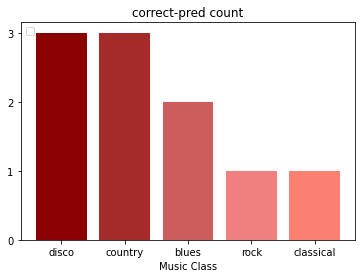

In [ ]:
colors1 = ['#8b0000', '#a52a2a', '#cd5c5c', '#f08080', '#fa8072',
          '#e9967a', '#ffa07a', '#ffdab9', '#ffe4c4', '#ffe4b5']

#제대로 분류한 애들
c2 = table[table['total_pred'] == table['ex_label']]
t2 = pd.DataFrame(c2['ex_label'].value_counts())
ratio2 = t2['ex_label']
labels2 = t2.index.tolist()
index2 = np.arange(0, max(ratio2)+1)

plt.bar(labels2, ratio2, color=colors1)
plt.title('correct-pred count')
plt.xlabel('Music Class')
plt.yticks(index2)
plt.legend(loc='upper left')

plt.show()

No handles with labels found to put in legend.


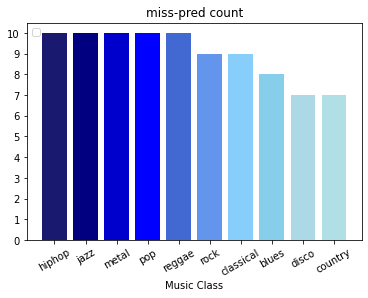

In [ ]:
colors2 = ['#191970', '#000080', '#0000cd', '#0000ff', '#4169d1',
           '#6495ed', '#87cefa', '#87ceeb', '#add8e6', '#b0e0e6']

#제대로 분류 못한 애들
c = table[table['total_pred'] != table['ex_label']]
tt = pd.DataFrame(c['ex_label'].value_counts())
ratio = tt['ex_label']
labels = tt.index.tolist()
index = np.arange(0, max(ratio)+1)

plt.bar(labels, ratio, color=colors2)
plt.title('miss-pred count')
plt.xlabel('Music Class')
plt.xticks(rotation=30)
plt.yticks(index)
plt.legend(loc='upper left')

plt.show()

No handles with labels found to put in legend.


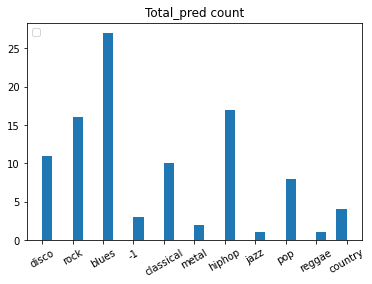

In [ ]:
# a = table['ex_label']
b = table['total_pred']

plt.hist(b, bins = 30)
plt.title('Total_pred count')
plt.xticks(rotation=30)
plt.legend(loc='upper left')

plt.show()